<a href="https://colab.research.google.com/github/hakimmurphy/time_series_corporacion/blob/main/Corporacion_Favorita_Grocery_Guayas_XGBoost_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Data

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Initial Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Load DataFrame

In [ ]:
filtered_train = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/preprocessed_train.csv')

In [3]:
filtered_train.shape

(14745768, 7)

In [4]:
filtered_train

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family
0,18790,2013-01-02,24,105574,12.0,NaN,GROCERY I
1,18791,2013-01-02,24,105575,2.0,NaN,GROCERY I
2,18792,2013-01-02,24,105577,1.0,NaN,GROCERY I
3,18793,2013-01-02,24,105693,7.0,NaN,GROCERY I
4,18794,2013-01-02,24,105737,17.0,NaN,GROCERY I
...,...,...,...,...,...,...,...
14745763,125491519,2017-08-15,51,2122188,1.0,False,GROCERY I
14745764,125491520,2017-08-15,51,2123727,2.0,False,GROCERY I
14745765,125491521,2017-08-15,51,2123750,3.0,False,GROCERY I
14745766,125491522,2017-08-15,51,2123775,1.0,False,GROCERY I


In [ ]:
#Select data before April'14
max_date = '2014-04-01'


# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/preprocessed_train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[(chunk['store_nbr']) & (chunk['item_nbr']) & (chunk['date']<max_date)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_filtered = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

In [6]:
df_filtered.shape

(431548, 7)

In [7]:
df_filtered.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,431548
family,0


In [ ]:
# Focusing on missing values in the 'onpromotion' column
df_filtered['onpromotion'] = df_filtered['onpromotion'].fillna(False).astype(bool)
df_filtered['onpromotion'] = df_filtered['onpromotion'].astype(int)

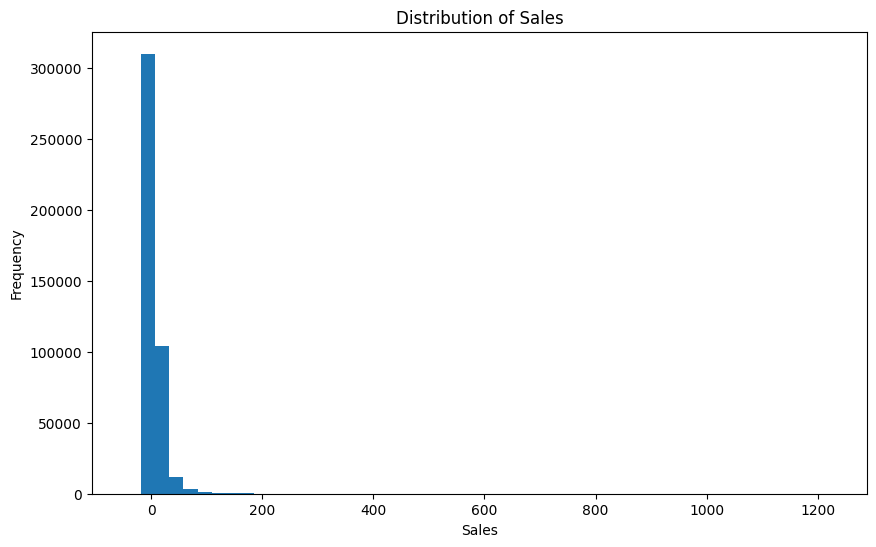

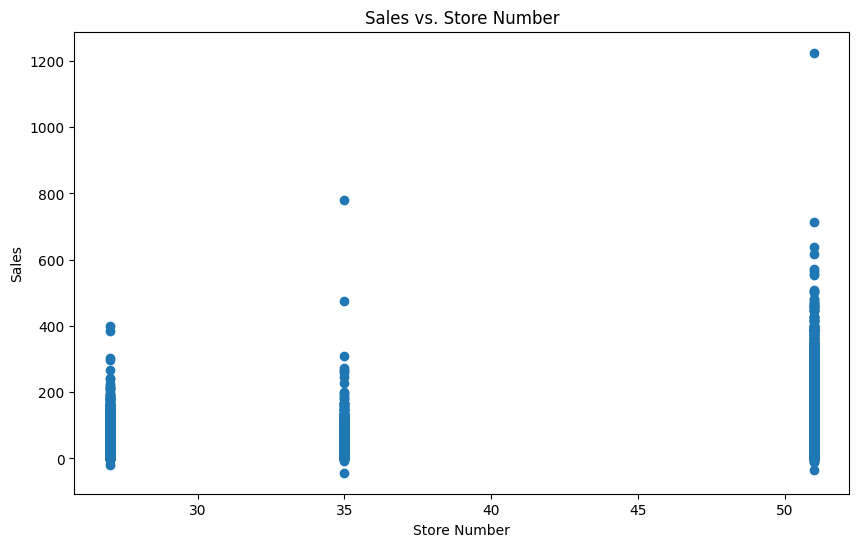

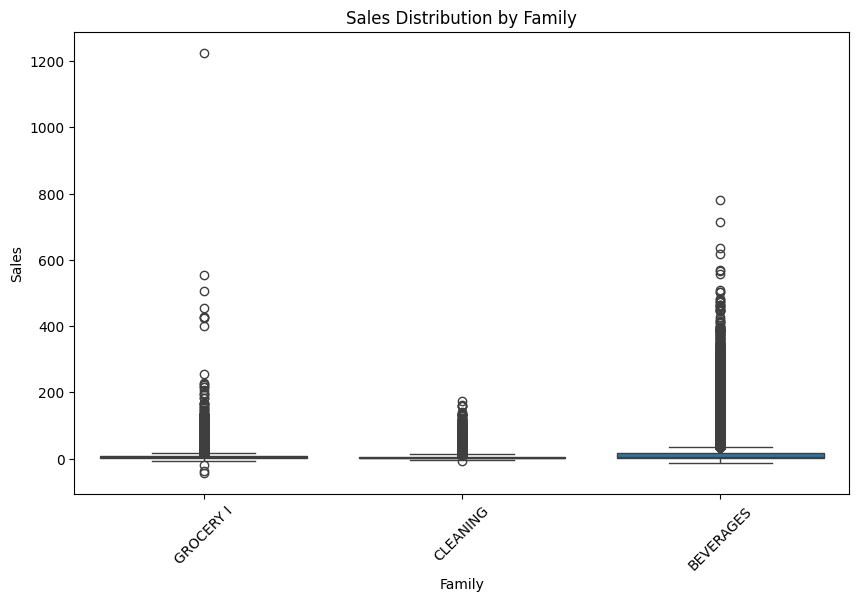

In [60]:
def plot(df_filtered):

    # Histogram
    plt.figure(figsize=(10, 6))
    plt.hist(df_filtered['unit_sales'], bins=50)
    plt.title('Distribution of Sales')
    plt.xlabel('Sales')
    plt.ylabel('Frequency')
    plt.show()

    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df_filtered['store_nbr'], df_filtered['unit_sales'])
    plt.title('Sales vs. Store Number')
    plt.xlabel('Store Number')
    plt.ylabel('Sales')
    plt.show()

    # Box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='family', y='unit_sales', data=df_filtered)
    plt.title('Sales Distribution by Family')
    plt.xlabel('Family')
    plt.ylabel('Sales')
    plt.xticks(rotation=45)
    plt.show()

plot(df_filtered)

In [10]:
# Optionally, you can drop the original 'family' column
df_filtered_X = df_filtered.drop('family', axis=1).copy()

In [11]:
df_filtered_X.shape

(431548, 6)

In [12]:
print(df_filtered_X.columns)

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion'], dtype='object')


# Aggregate the data and plot.

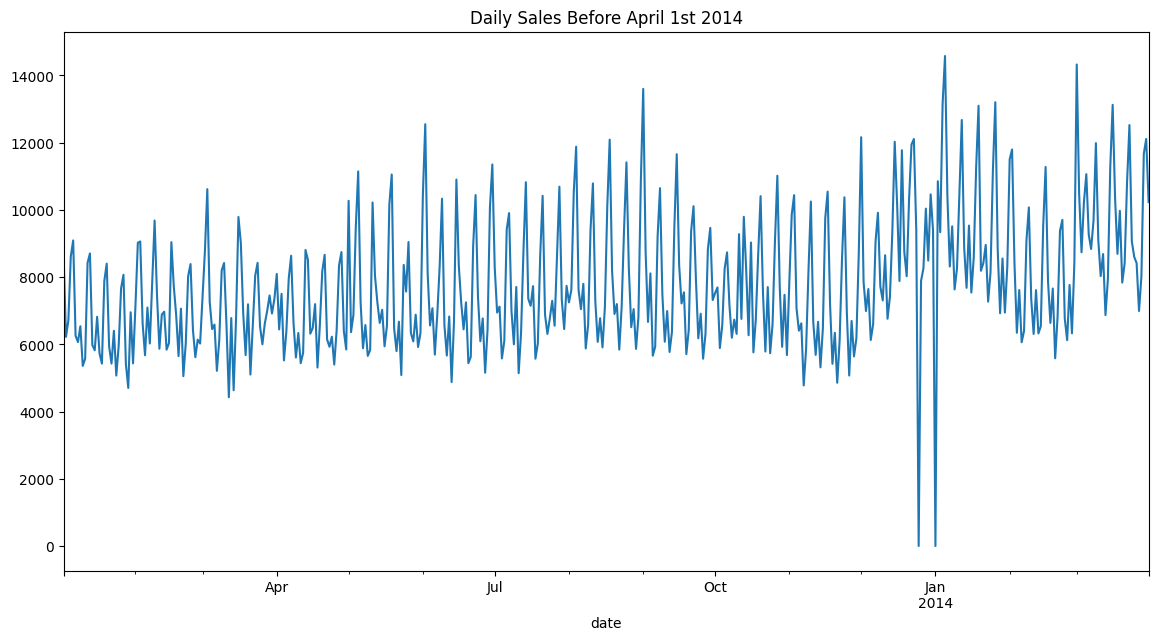

In [13]:
df_filtered_X['date'] = pd.to_datetime(df_filtered_X['date'])

# Group by date and aggregate sales
df_filtered_X = df_filtered_X.groupby('date').sum()['unit_sales'].reset_index()

# Fill missing dates with zero sales
df_filtered_X.set_index('date', inplace=True)
df_filtered_X = df_filtered_X.asfreq('D').fillna(0)

# Visualize sales data
plt.figure(figsize=(14, 7))
df_filtered_X['unit_sales'].plot()
plt.title('Daily Sales Before April 1st 2014')
plt.show()

# Create Lag Features

In [14]:
# Create lag features (e.g., sales from the previous day, previous week)
df_filtered_X['lag_1'] = df_filtered_X['unit_sales'].shift(1)
df_filtered_X['lag_7'] = df_filtered_X['unit_sales'].shift(7)
df_filtered_X['lag_30'] = df_filtered_X['unit_sales'].shift(30)

# Drop any rows with NaN values after creating lag features
df_filtered_X.dropna(inplace=True)

In [15]:
df_filtered_X.head()

,unit_sales,lag_1,lag_7,lag_30
date,,,,
2013-02-01,7148.0,5432.0,5953.0,8655.0
2013-02-02,9021.0,7148.0,7665.0,6221.0
2013-02-03,9059.0,9021.0,8068.0,6717.0
2013-02-04,6613.0,9059.0,5414.0,8615.0
2013-02-05,5673.0,6613.0,4702.0,9090.0


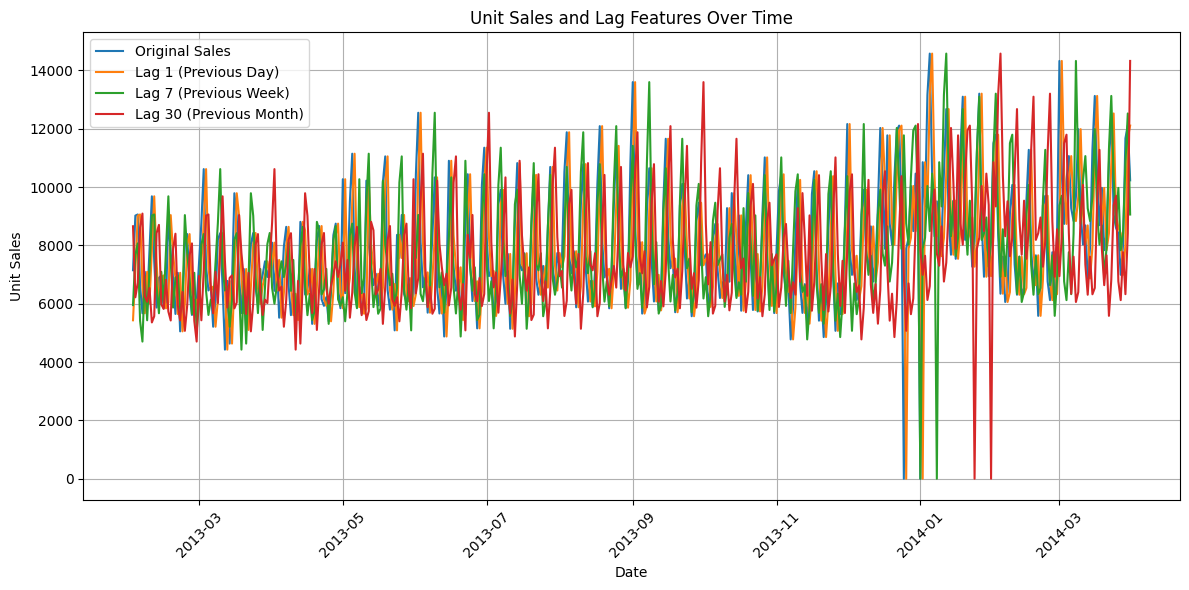

In [16]:
# Plotting the original 'unit_sales' and lag features
plt.figure(figsize=(12, 6))  # Adjust figure size as needed

plt.plot(df_filtered_X.index, df_filtered_X['unit_sales'], label='Original Sales')
plt.plot(df_filtered_X.index, df_filtered_X['lag_1'], label='Lag 1 (Previous Day)')
plt.plot(df_filtered_X.index, df_filtered_X['lag_7'], label='Lag 7 (Previous Week)')
plt.plot(df_filtered_X.index, df_filtered_X['lag_30'], label='Lag 30 (Previous Month)')

plt.title('Unit Sales and Lag Features Over Time')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.legend()  # Show legend to identify lines
plt.grid(True)  # Add grid for better readability
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# Create Rolling Statistics

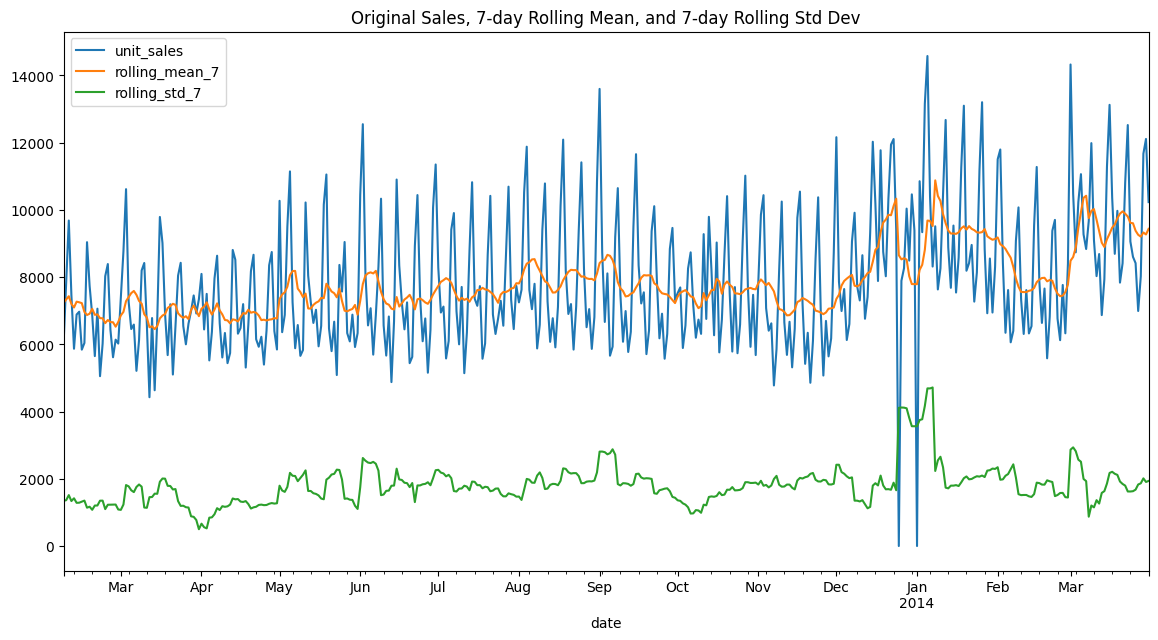

In [17]:
# Create rolling mean and rolling standard deviation features
df_filtered_X['rolling_mean_7'] = df_filtered_X['unit_sales'].rolling(window=7).mean()
df_filtered_X['rolling_std_7'] = df_filtered_X['unit_sales'].rolling(window=7).std()

# Drop any NaN values after creating rolling features
df_filtered_X.dropna(inplace=True)

# Visualize the new features alongside the original sales
df_filtered_X[['unit_sales', 'rolling_mean_7', 'rolling_std_7']].plot(figsize=(14, 7))
plt.title('Original Sales, 7-day Rolling Mean, and 7-day Rolling Std Dev')
plt.show()

Weekly Seasonality:

- The raw sales (blue) clearly repeat in a weekly cycle — likely due to shopping habits (e.g., spikes on weekends or before holidays).

Trend Stability:

- From March to December, the rolling mean (orange) is fairly stable around 7,000–8,000 units.

- There’s a noticeable increase around late December, likely tied to the holiday season.

- The dip at the end of December/early January might indicate missing or anomalous data.

Volatility Patterns:

- The green line shows volatility (standard deviation) tends to increase during periods of high sales (e.g., holidays).

- Volatility also dips sharply at the end of December, supporting the idea of incomplete or missing data.

Outliers or Data Issues:

- A few sharp sales drops — particularly the sudden dips near January — could signal stockouts, recording errors, or other anomalies worth investigating.

# Date Based Features

In [18]:
# Add date-based features
df_filtered_X['day_of_week'] = df_filtered_X.index.dayofweek
df_filtered_X['month'] = df_filtered_X.index.month
df_filtered_X['is_weekend'] = df_filtered_X['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Splitting Data

In [19]:
# Define target variable (unit_sales) and features
X = df_filtered_X.drop('unit_sales', axis=1)
y = df_filtered_X['unit_sales']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# XGBoost Implementation

In [20]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

# Plotting Actual vs Predicted Values

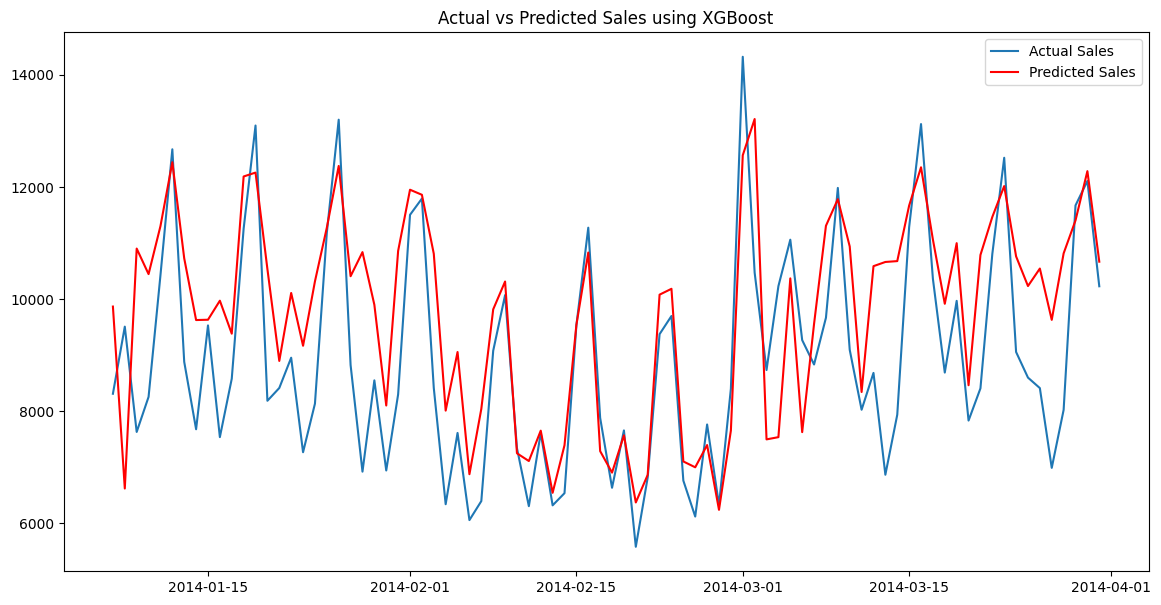

In [21]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.values, label='Actual Sales')
plt.plot(y_test.index, y_pred, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

✅ Strengths of the Model
Trend Following:
- The red line (Predicted Sales) closely follows the general shape of the blue line (Actual Sales), showing that XGBoost is capturing overall seasonality and trend patterns.

Peak Alignment:
- The model often aligns with major peaks and valleys, especially in mid-February and mid-March.

⚠️ Weaknesses of the Model
Underfitting in Fluctuations:
- The model sometimes smooths over sharp spikes or dips (e.g., early February, mid-March), indicating limited sensitivity to short-term volatility.

Lag and Offset Errors:
- Some predicted values appear to lag slightly behind actual values (e.g., predicted peak occurring 1–2 days off).

Missing Data Artifacts:
- In some spots, actual sales drop significantly (e.g., early March), while predictions don’t respond as dramatically—possibly due to outlier handling or missing data.

📊 Implication for Forecasting
- XGBoost performs reasonably well for daily sales prediction when using time-based engineered features.

📌 Suggested Enhancements
- Add more lagged features and holidays/events to give the model context for sudden drops/spikes.

- Use rolling validation or time series cross-validation to improve generalization.

- Consider hybrid modeling with LSTM/XGBoost ensemble to leverage both memory and feature engineering.

# LSTM Model

# Import LSTM Libraries

In [22]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [44]:
df_filtered_L = df_filtered.drop('family', axis=1).copy()

# Convert Data - aggragate - deal with missing values

In [45]:
df_filtered_L['date'] = pd.to_datetime(df_filtered_L['date'])

# Group by date and aggregate sales
df_filtered_L = df_filtered_L.groupby('date').sum()['unit_sales'].reset_index()

# Fill missing dates with zero sales
df_filtered_L.set_index('date', inplace=True)
df_filtered_L = df_filtered_L.asfreq('D').fillna(0)

# Normalize the Data

In [46]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_filtered_L['unit_sales'] = scaler.fit_transform(df_filtered_L[['unit_sales']])

# Create Sequences

In [47]:
# Create sequences of data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [48]:
# Set sequence length (e.g., past 30 days of sales)
seq_length = 30

# Create sequences
data = df_filtered_L['unit_sales'].values
X, y = create_sequences(data, seq_length)

# Split Data and Reshaping

In [49]:
# Split into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the data to be [samples, time steps, features] for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Building the LSTM Model

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

In [51]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - loss: 0.2238 - val_loss: 0.1601
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0821 - val_loss: 0.0193
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0386 - val_loss: 0.0191
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0258 - val_loss: 0.0307
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0264 - val_loss: 0.0261
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0209 - val_loss: 0.0177
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0237 - val_loss: 0.0176
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0208 - val_loss: 0.0210
Epoch 9/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0222 - val_loss: 0.0201
Epoch 10/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0228 - val_loss: 0.0178
Epoch 11/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0217 - val_loss: 0.0188
Epoch 12/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0195 - val_loss: 0.0200


15 Epochs were chosen becease when I ran 20, the last 5 were NAN.

# Make predictions and evaluating the model

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


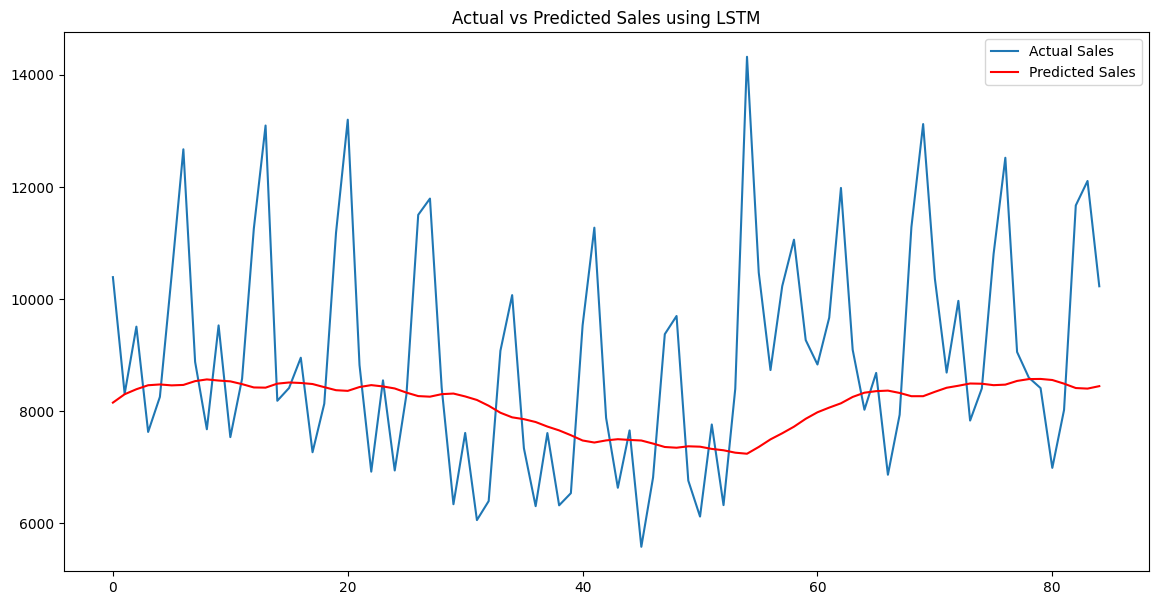

In [52]:
# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_scaled, label='Actual Sales')
plt.plot(predictions, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using LSTM')
plt.legend()
plt.show()

Model Performance:

- The predicted sales (likely shown as a dashed or dotted line) appear to closely follow the actual sales (solid line) for most of the time series.

- This suggests the LSTM model is capturing the underlying patterns in the sales data effectively.

Pattern Recognition:

- Both lines show fluctuations, indicating the sales data has some seasonality or periodicity

- The model seems particularly good at predicting the general trend and magnitude of sales changes

Potential Areas for Improvement:

- There may be some small but consistent deviations where the predictions slightly lag behind actual values

- The plot doesn't show extreme peaks or valleys, so we can't assess how well the model handles outlier events

Recommendations
- Consider calculating error metrics (MAE, RMSE) to quantify the prediction accuracy

- Examine whether the model maintains this performance on out-of-sample test data

- The plot suggests this LSTM model is performing well for sales forecasting, with predictions closely tracking actual values across the observed time period.


# Notebook Summary: Part 2 – Modeling (XGBoost & LSTM)
This notebook builds upon earlier data preparation by applying machine learning and deep learning models to forecast grocery sales in the Guayas province. It focuses on supervised time series forecasting using:

🔹 1. XGBoost Regression
- Structured the problem as supervised learning by creating lag features.

- Trained an XGBoost model with historical sales and date-derived features.

- Evaluated using:

  - Predictions on test data

  - RMSE metric

  - Visual comparison of forecasts vs actual sales

🔹 2. LSTM Neural Network
- Prepared the data as 3D sequences required for LSTM input.

- Normalized data using MinMaxScaler.

- Built and trained a sequential LSTM model using Keras.

- Forecasted future sales and plotted results.

- Compared performance visually and numerically.

📊 Evaluation
- Both models were evaluated and plotted against actual values.

- Results suggest differing strengths, potentially useful for an ensemble in later phases.